In [335]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

class fuzzy():
    def __init__(self):
        self.inputvars = {}
        self.outputvars = {}
        self.rules = {}
        self.__npoints = 200
        self.__points__= {"input":{},"output":{}}

    def __str__(self) -> str:
        print(f"input vars: {', '.join(list(self.inputvars.keys()))}")
        print(f"output vars: {', '.join(list(self.outputvars.keys()))}")
    
    def showrules(self):
        for r,v in self.rules.items():
            ant = []
            for varin in self.inputvars:
                ant.append(f"{varin} is {v['antecedent'][varin]}")
            con = []
            for varout in self.outputvars:
                con.append(f"{varout} is {v['consequent'][varout]}")
            
            print(f"if {'and '.join(ant)} then {'and '.join(con)}")

    def add_var(self,varslist):
        if isinstance(varslist,list):
            for item in varslist:
                if item["type"]=='input':
                    self.inputvars[item["name"]] = {"id":len(self.inputvars)+1,"range":item["range"],"mfs":{}}
                    # self.__points__["input"][item["name"]]=np.linspace(item["range"][0],item["range"][1],200)
                if item["type"]=='output':
                    self.outputvars[item["name"]] = {"id":len(self.outputvars)+1,"range":item["range"],"mfs":{}}
                    self.__points__["output"][item["name"]]=np.linspace(item["range"][0],item["range"][1],self.__npoints)
        if isinstance(varslist,dict):
            if varslist["type"]=='input':
                self.inputvars[varslist["name"]] = {"id":len(self.inputvars)+1,"range":varslist["range"],"mfs":{}}
                # self.__points__["input"][varslist["name"]]=np.linspace(varslist["range"][0],varslist["range"][1],200)
            if varslist["type"]=='output':
                self.outputvars[varslist["name"]] = {"id":len(self.outputvars)+1,"range":varslist["range"],"mfs":{}}
                self.__points__["output"][varslist["name"]]=np.linspace(varslist["range"][0],varslist["range"][1],self.__npoints)

    def add_mfs(self,obj):
        if isinstance(obj,list):
            for item in obj:
                self.add_mf(item["vartype"],item["varname"],item["mfname"],item["params"])
        
        if isinstance(obj,dict):
            self.add_mf(obj["vartype"],obj["varname"],obj["mfname"],obj["params"])
        
    def add_mf(self,vartype,varname, mfname,params):
        if vartype=='input':
            self.inputvars[varname]["mfs"][mfname]= {"id":len(self.inputvars[varname]["mfs"])+1,"params":params}
        if vartype=='output':
            self.outputvars[varname]["mfs"][mfname]= {"id":len(self.outputvars[varname]["mfs"])+1,"params":params}
    
    def add_rule(self,antecedent,consequent):
        self.rules[f"rule_{len(self.rules)+1}"] = {"antecedent":antecedent,"consequent":consequent} 
    
    def add_rules(self,antecedents,consequents):
        if isinstance(antecedent,list) and isinstance(consequents,list):
            for antecedent,consequent in zip(antecedents,consequents):
                self.rules[f"rule_{len(self.rules)+1}"] = {"antecedent":antecedent,"consequent":consequent} 

    def  trimf(self,x,params):
        eps = 1.0e-20
        a,b,c = params
        if x==b:
            return 1.0
        elif x <= a or x >=c:
            return 0.0
        elif a < x < b:
            return (x - a) / (b - a+eps)
        elif b < x < c:
            return (c - x) / (c - b+eps)
   

        
    def eval(self,x):
        eps = 1.0e-20
        if not isinstance(x,list):
            x = [x]
        
        res = {var:[0]*self.__npoints for var in self.outputvars.keys()}
        centroid = {}
        for r,v in self.rules.items():
            aux = []
            for id,vid in enumerate(v["antecedent"].items()):
                a,b = vid
                aux.append(self.trimf(x[id],self.inputvars[a]["mfs"][b]["params"]))
            
            cortex = min(aux)

            for sk,sv in  v["consequent"].items():
                for i,val in enumerate(self.__points__["output"][sk]):
                    res[sk][i]=max(res[sk][i],(min(cortex,self.trimf(val,self.outputvars[sk]["mfs"][sv]["params"]))))
                centroid[sk] = sum([a*b for a,b in zip(res[sk],self.__points__["output"][sk])])/(sum(res[sk])+eps)
        return centroid






In [341]:
fis = fuzzy()
fis.add_var({"type":"input","name":"pop","range":[0.0,1.0]})
fis.add_var({"type":"output","name":"varpop","range":[0.0,1.0]})
# fis.add_var({"type":"output","name":"ctrl","range":[0.0,1.0]})

fis.add_mfs({"vartype":"input","varname":"pop","mfname":"B","params":[0.0,0.0,0.5]})
fis.add_mfs({"vartype":"input","varname":"pop","mfname":"M","params":[0.0,0.5,1.0]})
fis.add_mfs({"vartype":"input","varname":"pop","mfname":"A","params":[0.5,1.0,1.0]})

fis.add_mfs({"vartype":"output","varname":"varpop","mfname":"B","params":[0.0,0.0,0.5]})
fis.add_mfs({"vartype":"output","varname":"varpop","mfname":"M","params":[0.0,0.5,1.0]})
fis.add_mfs({"vartype":"output","varname":"varpop","mfname":"A","params":[0.5,1.0,1.0]})

# fis.add_mfs({"vartype":"output","varname":"ctrl","mfname":"B","params":[0.0,0.0,0.5]})
# fis.add_mfs({"vartype":"output","varname":"ctrl","mfname":"M","params":[0.0,0.5,1.0]})
# fis.add_mfs({"vartype":"output","varname":"ctrl","mfname":"A","params":[0.5,1.0,1.0]})



fis.add_rule({"pop":"B"},{"varpop":"B"})
fis.add_rule({"pop":"M"},{"varpop":"M"})
fis.add_rule({"pop":"A"},{"varpop":"A"})

In [343]:
x,y,z = [],[],[]
for i in np.linspace(0,1,100):
    x.append(i)
    res = fis.eval(i)
    y.append(res["varpop"])
    

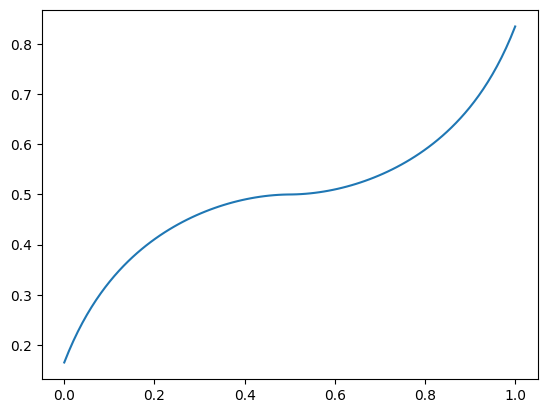

In [344]:
plt.plot(x,y)
plt.show()